# Player behavior analysis

### Abstract 

#### I synthesized a comprehensive casino session dataset and embedded latent archetypes reflecting distinct player behaviors. I assessed data quality by examining descriptive statistics, distribution shapes, skewness, and kurtosis to ensure realistic patterns. To identify similar players, I trained an LSTM-based sequence model to generate 64-dimensional embeddings and measured likeness using cosine similarity. I demonstrated this approach by detecting likely churners and flagging players exhibiting high-risk gambling behaviors. 


In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from collections import defaultdict

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Constants
num_players = 100
num_sessions = 10000
start_date = datetime(2025, 4, 19)
end_date = datetime(2025, 5, 19)
date_range = (end_date - start_date).days
game_titles = ["Mystic Quest 1", "Mystic Quest 2", "Golden Phoenix", "Dragon Slots", "Jungle Spin",
               "Ocean Riches", "Desert Mirage", "Frozen Fortune", "Cyber Spin", "Wild West Wins"]
age_groups = ["18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
age_group_probs = [0.05, 0.4, 0.2, 0.15, 0.1, 0.1]
distance_clusters = [np.random.normal(5, 2, 3000), np.random.normal(30, 10, 5000), np.random.normal(90, 5, 2000)]
distances = np.clip(np.concatenate(distance_clusters), 0, 100)

# Assign player IDs and archetypes
player_ids = [f"{str(i).zfill(3)}" for i in range(num_players)]
archetypes = np.random.choice(['high_roller', 'local_regular', 'lucky_streaker'], size=num_players, p=[0.3, 0.5, 0.2])
player_archetypes = dict(zip(player_ids, archetypes))

# Memory trackers
player_last_game = {}
player_sessions = defaultdict(list)

# Generate sessions
data = []
for i in range(num_sessions):
    player_id = random.choice(player_ids)
    archetype = player_archetypes[player_id]

    # Date bias: High rollers more likely near weekend
    if archetype == 'high_roller':
        weekday_weights = [0.5 if d >= 4 else 1.5 for d in range(7)]  # Fri–Sun (4–6) weighted more
        chosen_day = None
        while True:
            potential_day = start_date + timedelta(days=random.randint(0, date_range))
            if np.random.rand() < (weekday_weights[potential_day.weekday()] / max(weekday_weights)):
                chosen_day = potential_day
                break
    else:
        chosen_day = start_date + timedelta(days=random.randint(0, date_range))

    day_str = chosen_day.strftime("%Y-%m-%d")
    hour = np.random.randint(0, 24)
    minute = np.random.randint(0, 60)
    second = np.random.randint(0, 60)
    time_of_day = f"{hour:02d}:{minute:02d}:{second:02d}"

    # Alternating between two favorite games
    if player_id not in player_last_game:
        game_title = "Mystic Quest 1"
    else:
        game_title = "Mystic Quest 2" if player_last_game[player_id] == "Mystic Quest 1" else "Mystic Quest 1"
    player_last_game[player_id] = game_title

    # Archetype-driven behavior
    if archetype == 'high_roller':
        coin_in = np.random.uniform(800, 1500)
        time_on_device = np.random.uniform(1800, 3600)
        handle_pulls = np.random.poisson(100)
    elif archetype == 'local_regular':
        coin_in = np.random.uniform(20, 100)
        time_on_device = np.random.uniform(300, 1200)
        handle_pulls = np.random.poisson(20)
    else:
        coin_in = np.random.uniform(50, 500)
        time_on_device = np.random.uniform(100, 1000)
        handle_pulls = np.random.poisson(50)

    # Inject non-linear pattern: high coinIn with low time
    if np.random.rand() < 0.15:
        coin_in = np.random.uniform(1000, 1500)
        time_on_device = np.random.uniform(60, 300)

    handle_pulls = int(np.clip(handle_pulls, 1, 150))

    # NetWin logic: 10% chance of player winning
    if np.random.rand() < 0.1:
        net_win = -np.random.uniform(1, coin_in * 0.5)
    else:
        net_win = np.random.uniform(0, coin_in * 0.3)

    # Influence next session based on win/loss streak
    recent_sessions = player_sessions[player_id][-3:]
    if recent_sessions:
        avg_net_win = np.mean([s['netWin'] for s in recent_sessions])
        if avg_net_win < 0:  # recent losses
            coin_in *= np.random.uniform(1.2, 1.5)
        else:  # recent wins
            coin_in *= np.random.uniform(0.7, 0.9)

    age_group = np.random.choice(age_groups, p=age_group_probs)
    distance = float(np.random.choice(distances))

    session_data = {
        "playerId": player_id,
        "day": day_str,
        "timeOfDay": time_of_day,
        "gameTitle": game_title,
        "timeOnDevice": int(time_on_device),
        "netWin": round(net_win, 2),
        "coinIn": round(coin_in, 2),
        "ageGroup": age_group,
        "distance": round(distance, 2),
        "handlePulls": handle_pulls
    }

    player_sessions[player_id].append(session_data)
    data.append(session_data)

# Final DataFrame
df_sessions = pd.DataFrame(data)

df_sessions.head()
df_sessions.to_csv("/Users/yuqi/Downloads/synthetic_casino_sessions_initial3.csv", index=False)



# Data Evaluation 

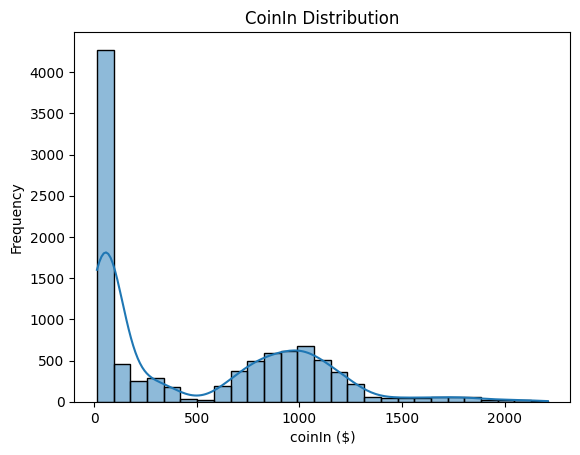

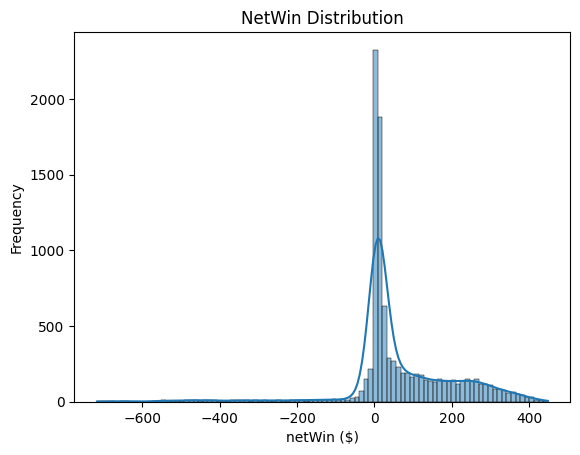

NetWin Skewness: -0.6259663917379569


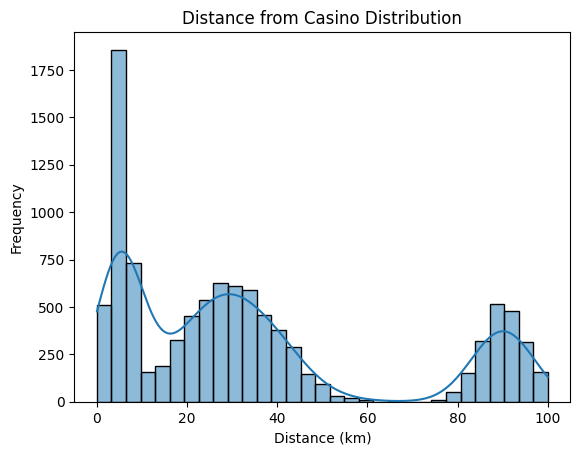

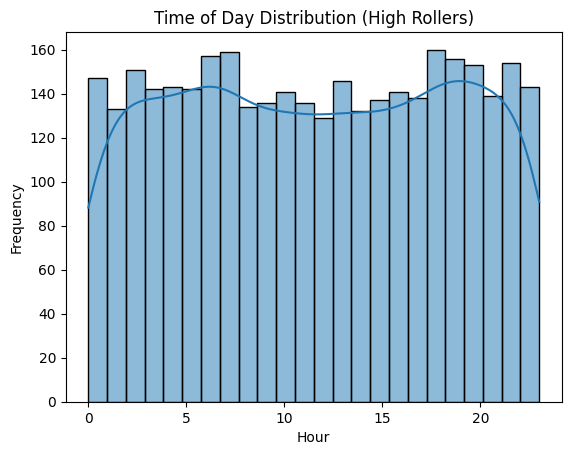

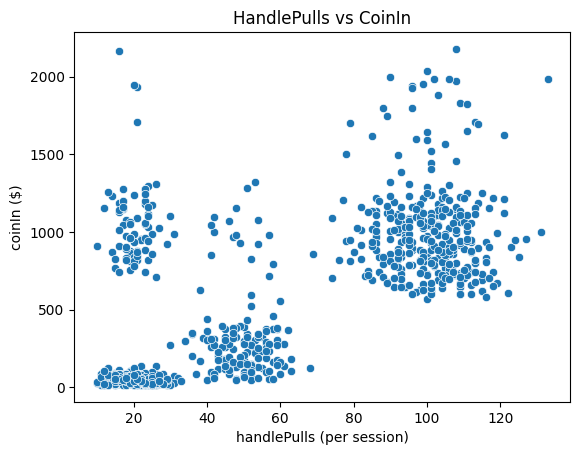

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# CoinIn distribution
sns.histplot(df_sessions['coinIn'], kde=True)
plt.title("CoinIn Distribution")
plt.xlabel("coinIn ($)")
plt.ylabel("Frequency")
plt.show()

# NetWin distribution
sns.histplot(df_sessions['netWin'], kde=True)
plt.title("NetWin Distribution")
plt.xlabel("netWin ($)")
plt.ylabel("Frequency")
plt.show()

# Skew of netWin
print("NetWin Skewness:", df_sessions['netWin'].skew())

# Distance distribution
sns.histplot(df_sessions['distance'], kde=True)
plt.title("Distance from Casino Distribution")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()

# Hour of day distribution for high rollers
df_sessions['hour'] = df_sessions['timeOfDay'].str[:2].astype(int)
high_roller_ids = [pid for pid, a in player_archetypes.items() if a == 'high_roller']
sns.histplot(df_sessions[df_sessions['playerId'].isin(high_roller_ids)]['hour'], bins=24, kde=True)
plt.title("Time of Day Distribution (High Rollers)")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.show()

# CoinIn vs HandlePulls
sns.scatterplot(x='handlePulls', y='coinIn', data=df_sessions.sample(1000))
plt.title("HandlePulls vs CoinIn")
plt.xlabel("handlePulls (per session)")
plt.ylabel("coinIn ($)")
plt.show()

In [13]:
# check skewness and kurtosis 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import skew, kurtosis
df = df_sessions.copy()
df['hour'] = df['timeOfDay'].str[:2].astype(int)

label_encoders = {}
for col in ['gameTitle', 'ageGroup']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df['datetime'] = pd.to_datetime(df['day'] + ' ' + df['timeOfDay'])
df = df.sort_values(['playerId', 'datetime'])

features = ['coinIn', 'netWin', 'timeOnDevice', 'handlePulls', 'hour', 'gameTitle', 'ageGroup', 'distance']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_skewness = pd.Series({f: skew(df[f]) for f in features})
feature_kurtosis = pd.Series({f: kurtosis(df[f]) for f in features})

stats_df = pd.DataFrame({'Skewness': feature_skewness, 'Kurtosis': feature_kurtosis})
print(stats_df)

              Skewness  Kurtosis
coinIn        0.655758 -0.643352
netWin       -0.625872  4.544678
timeOnDevice  0.924990 -0.543446
handlePulls   0.506649 -1.430565
hour         -0.011539 -1.200070
gameTitle     0.009200 -1.999915
ageGroup      0.671069 -0.660952
distance      0.926074 -0.468415


In [14]:
# data summary
df = df_sessions.copy()
df['hour'] = df['timeOfDay'].str[:2].astype(int)
df['gameCode'] = df['gameTitle'].astype('category').cat.codes
df['ageCode']  = df['ageGroup'].astype('category').cat.codes

numeric_cols = [
    'coinIn', 'netWin', 'timeOnDevice', 'handlePulls',
    'distance', 'hour', 'gameCode', 'ageCode'
]

stats_df = df[numeric_cols].describe().T

print(stats_df)

                count         mean          std     min     25%      50%  \
coinIn        10000.0   511.298741   506.205938   14.35   55.59  262.095   
netWin        10000.0    65.821284   137.265954 -716.94    5.27   18.900   
timeOnDevice  10000.0  1197.350900  1034.174930   60.00  402.00  813.000   
handlePulls   10000.0    52.149000    36.969229    7.00   20.00   31.000   
distance      10000.0    34.328380    30.654781    0.00    6.80   26.970   
hour          10000.0    11.522400     6.913181    0.00    6.00   12.000   
gameCode      10000.0     0.497700     0.500020    0.00    0.00    0.000   
ageCode       10000.0     2.149200     1.428966    0.00    1.00    2.000   

                    75%      max  
coinIn         954.4375  2209.33  
netWin         133.4825   447.85  
timeOnDevice  2056.5000  3598.00  
handlePulls     94.0000   141.00  
distance        42.6825   100.00  
hour            18.0000    23.00  
gameCode         1.0000     1.00  
ageCode          3.0000     5.00  


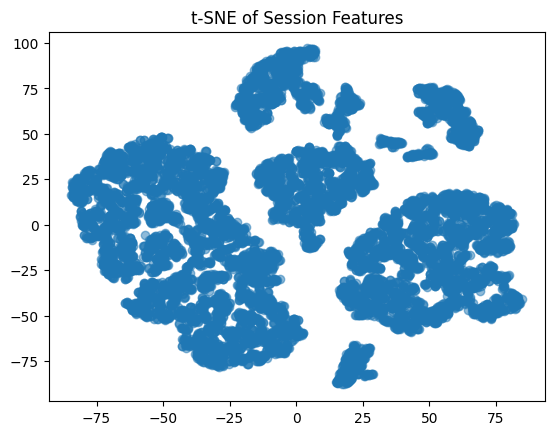

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

X = df_sessions[['coinIn', 'timeOnDevice', 'handlePulls', 'netWin']]
X_scaled = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.5)
plt.title("t-SNE of Session Features")
plt.show()

### Key percentiles of player sessions

count    100.000000
mean     100.000000
std       10.103505
min       78.000000
25%       92.750000
50%      100.000000
75%      107.250000
max      124.000000
dtype: float64
50th percentile (median): 100.0
75th percentile: 107.25
90th percentile: 112.0


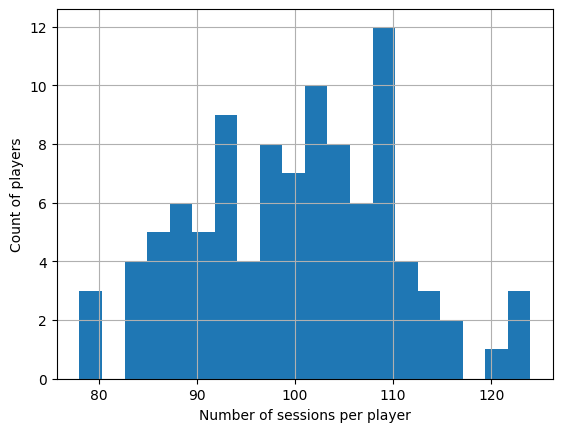

In [15]:
# 1) Compute sessions per player
session_counts = df.groupby('playerId').size()

# 2) Get descriptive stats
print(session_counts.describe())
# e.g. count, mean, std, min, 25%, 50%, 75%, max

# 3) Look at key percentiles
print("50th percentile (median):", session_counts.quantile(0.50))
print("75th percentile:",        session_counts.quantile(0.75))
print("90th percentile:",        session_counts.quantile(0.90))

# 4) Visualize with a histogram
import matplotlib.pyplot as plt
session_counts.hist(bins=20)
plt.xlabel("Number of sessions per player")
plt.ylabel("Count of players")
plt.show()

### Plausibility check - loss chasing

Average coinIn after previous session:
prev_loss
False    510.259580
True     521.279311
Name: coinIn, dtype: float64


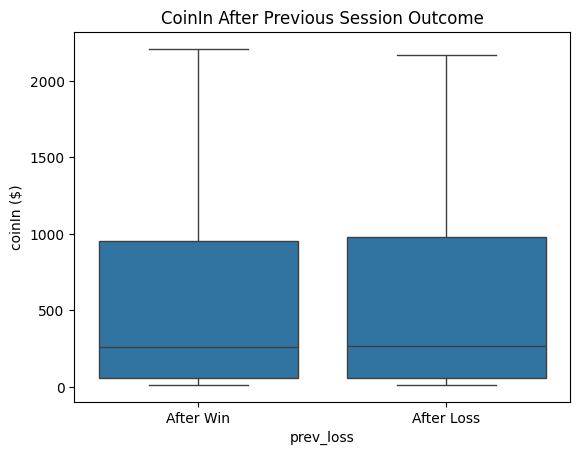

In [5]:
# Sort by player and time
df_sessions['datetime'] = pd.to_datetime(df_sessions['day'] + ' ' + df_sessions['timeOfDay'])
df_sorted = df_sessions.sort_values(['playerId', 'datetime'])

# Shift to get previous session's netWin
df_sorted['prev_netWin'] = df_sorted.groupby('playerId')['netWin'].shift(1)
df_sorted['prev_coinIn'] = df_sorted.groupby('playerId')['coinIn'].shift(1)

# Mark previous loss
df_sorted['prev_loss'] = df_sorted['prev_netWin'] < 0

# Compare coinIn after previous win vs loss
loss_chasing = df_sorted.groupby('prev_loss')['coinIn'].mean()
print("Average coinIn after previous session:")
print(loss_chasing)

# Optional: boxplot for visualization
sns.boxplot(x='prev_loss', y='coinIn', data=df_sorted)
plt.xticks([0, 1], ['After Win', 'After Loss'])
plt.title("CoinIn After Previous Session Outcome")
plt.ylabel("coinIn ($)")
plt.show()

# Model

This part is to turn raw session logs into fixed-length embeddings that capture each player’s temporal behavior.

	1.	Cyclical Time Encoding
	•	dow and hour extract the day-of-week (0–6) and hour-of-day (0–23).
	•	Converting them to sine and cosine (dow_sin, dow_cos, hr_sin, hr_cos) maps these periodic variables onto the unit circle, so the model understands that Sunday (6) and Monday (0) are adjacent, and that 23:00 and 00:00 are only one hour apart.
	
    2.	Win Flag & Loss Weights
	•	The player_win binary feature marks jackpot sessions (netWin < 0) so the network can treat wins differently.
	•	loss_weight assigns a higher training penalty (weight = 3) to those rare win sessions when used during an auto-encoding loss, ensuring the model pays extra attention to them.
	
    3.	Sequence Assembly & Padding
	•	Sessions are sorted by timestamp (dt) per player, then grouped into an ordered list of feature vectors (seq).
	•	Because players have different numbers of sessions, I use pad_sequences to truncate or pad all sequences to a uniform length (90th quantile of player session - 112).  Padding with zeros at the front and masking them in the network lets shorter histories fit without contaminating the learned patterns.
	
    4.	LSTM Encoder Architecture
	•	A Masking layer ignores padded zeros so the LSTM only processes real sessions.
	•	The LSTM(128) layer ingests the 50×N feature matrix and compresses the temporal dynamics into a 128-dimensional hidden state.
	•	A final Dense(64) layer projects that hidden state down to a 64-dimensional “player embedding” vector, which succinctly encodes each player’s wagering behavior, temporal routines, game alternation, and win/loss dynamics.

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

df['dow']  = pd.to_datetime(df['day']).dt.weekday     # 0=Mon … 6=Sun
df['hour'] = df['timeOfDay'].str[:2].astype(int)      # 0–23

df['dow_sin'] = np.sin(2*np.pi * df['dow']  / 7)
df['dow_cos'] = np.cos(2*np.pi * df['dow']  / 7)
df['hr_sin']  = np.sin(2*np.pi * df['hour'] / 24)
df['hr_cos']  = np.cos(2*np.pi * df['hour'] / 24)

df['dt'] = pd.to_datetime(df['day'] + ' ' + df['timeOfDay'])
df = df.sort_values(['playerId','dt'])
features = ['coinIn','netWin','timeOnDevice','handlePulls','dow_sin','dow_cos','hr_sin','hr_cos']

# flag the player win
df['player_win'] = (df['netWin'] < 0).astype(float)
features.append('player_win')
# put more penalty on reconstructing or predicting win-sessions correctly
df['loss_weight'] = np.where(df['player_win']==1, 3.0, 1.0)


sequences = []
player_list = []
for pid, group in df.groupby('playerId'):
    seq = group[features].values       # shape (n_sessions, n_features)
    sequences.append(seq)
    player_list.append(pid)

# Pad to a common length (max_sessions here is decided from 90th quantile of player sessions) and build a mask

X = pad_sequences(
    sequences,
    maxlen=112,
    dtype='float32',
    padding='post',
    truncating='post'
)

inp = Input((112, len(features)))
x   = Masking(mask_value=0.0)(inp)
x   = LSTM(128)(x)
out = Dense(64, activation='relu')(x)
model = Model(inp, out)

In [20]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_players = X #copy X

# Get embeddings from LSTM model
#(model outputs the 64-dim embedding per player)
embeddings = model.predict(X_players)   # shape (num_players, 64)

# Compute cosine similarity matrix
sim_matrix = cosine_similarity(embeddings)  # shape (num_players, num_players)

# Wrap it in a DataFrame for readability
import pandas as pd
sim_df = pd.DataFrame(sim_matrix, index=player_list, columns=player_list)

# For a given player “P010”, find top 5 most similar peers
player = '010'
top5 = sim_df[player].sort_values(ascending=False).iloc[1:6]  #skip self at index 0
print(f"Top 5 players similar to {player}:\n", top5)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Top 5 players similar to 010:
 063    0.996333
098    0.994458
094    0.976160
086    0.973580
081    0.971546
Name: 010, dtype: float32


In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

# 1) Prepare datetime column
df['datetime'] = pd.to_datetime(df['day'] + ' ' + df['timeOfDay'])

# 2) Build churn labels (1 = churned: no sessions in last day)
last_session = df.groupby('playerId')['datetime'].max()
cutoff       = df['datetime'].max() - pd.Timedelta(days=1)
churn_series = (last_session < cutoff).astype(int)
y_churn      = np.array([ churn_series.get(pid, 0) for pid in player_list ])

# 3) Train a simple churn‐risk model
clf         = LogisticRegression().fit(embeddings, y_churn)
risk_scores = clf.predict_proba(embeddings)[:, 1]

# find churn risky players 
sorted_idx = np.argsort(-risk_scores)
high_risk_players = [player_list[i] for i in sorted_idx[:10]]
print("Top 10 high-churn-risk players:", high_risk_players)

# ——————————————————————————————————————————————
# 4) Define a “risky” prototype embedding
#    (top 10% by average wager AND high fraction of 0–4 AM play)
df['hour']           = df['timeOfDay'].str[:2].astype(int)
group                = df.groupby('playerId')
avg_coinin           = group['coinIn'].mean()
late_night_frac      = group.apply(lambda g: ((g['hour'] >= 0) & (g['hour'] <= 4)).mean())
coin_thresh          = avg_coinin.quantile(0.90)
night_thresh         = late_night_frac.quantile(0.90)
risky_players        = avg_coinin[(avg_coinin > coin_thresh) &
                                  (late_night_frac > night_thresh)].index
risky_indices        = [player_list.index(pid) for pid in risky_players if pid in player_list]
risky_centroid       = embeddings[risky_indices].mean(axis=0)

# 5) Flag high‐risk gamblers by cosine similarity
sim_to_risky = cosine_similarity(embeddings, risky_centroid.reshape(1, -1)).ravel()
sim_series = pd.Series(sim_to_risky, index=player_list)
high_risk = sim_series[sim_series > 0.8]
print("High‐risk players (sim > 0.8):")
print(high_risk)

# top N most similar (highest risk) players
#top_10 = sim_series.nlargest(10)
#print("\nTop 10 highest‐risk players:")
#print(top_10)

Top 10 high-churn-risk players: ['060', '094', '013', '040', '069', '071', '006', '024', '050', '009']
High‐risk players (sim > 0.8):
014    0.821580
031    0.907487
033    1.000000
035    0.818944
041    0.818087
056    0.820895
062    0.851510
068    0.918609
084    0.945347
089    0.832534
dtype: float32


/var/folders/tm/z749zy7x1673143rgv5s8tz40005dx/T/ipykernel_98617/2860200113.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  late_night_frac      = group.apply(lambda g: ((g['hour'] >= 0) & (g['hour'] <= 4)).mean())
